In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [35]:
solar_power= pd.read_csv("solar_data.csv", parse_dates=True, index_col='Timestamp')

data = solar_power[['Power_Generated']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

C:\Users\Pakhi Sharma\AppData\Local\Temp\ipykernel_21128\1495987235.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  solar_power= pd.read_csv("solar_data.csv", parse_dates=True, index_col='Timestamp')


In [36]:
solar_power.head()
print(solar_power.index.dtype)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

datetime64[ns]


In [37]:
# Preprocessing
features = solar_power[['Solar_Radiation', 'Air_Temp', 'Relative_Humidity','Wind_Speed','Wind_Direction','Array_Voltage','Array_Current']]
features.info()
target= 'Power_Generated'
scaler = MinMaxScaler()
# MinMaxScaler scales each feature to the range [0, 1].
scaled_data = scaler.fit_transform(features)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1009 entries, 2022-04-27 15:32:00 to 2022-04-29 01:08:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Solar_Radiation    1009 non-null   float64
 1   Air_Temp           1009 non-null   float64
 2   Relative_Humidity  1009 non-null   float64
 3   Wind_Speed         1009 non-null   float64
 4   Wind_Direction     1009 non-null   float64
 5   Array_Voltage      1009 non-null   float64
 6   Array_Current      1009 non-null   float64
dtypes: float64(7)
memory usage: 63.1 KB


Create Time Series Sequences

SEQ_LEN specifies how many past time steps to use to predict the next time step


In [38]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # All features except the target
        y.append(data[i+seq_length, -1])     # Target column: Power_Generated
    return np.array(X), np.array(y)

SEQ_LEN = 13 # e.g., use past 13 time steps to predict the next

X, y = create_sequences(scaled_data, SEQ_LEN) # Create overlapping time sequences for time series prediction.
# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



You add an LSTM layer: 64: Number of LSTM units (i.e., neurons in this layer).
return_sequences=False: Only the last output in the output sequence will be returned, not the full sequence.  
input_shape=(X_train.shape[1], X_train.shape[2]): Shape of input data: X_train.shape[1] → number of time steps (sequence length)
X_train.shape[2] → number of features at each step

In [39]:
# Model Creation
model = Sequential()

# First LSTM layer with return_sequences=True (to pass full sequence to next LSTM)
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Second LSTM layer with return_sequences=True
model.add(LSTM(64, return_sequences=True))

# Third (last) LSTM layer with return_sequences=False
model.add(LSTM(64, return_sequences=False))

# Output layer
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# Model Training
history = model.fit(X_train, y_train, epochs=40, batch_size=16, validation_split=0.2)
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
full_target_scaler = MinMaxScaler() # Creates a new scaler to reverse the normalization for the target variable only.
full_target_scaler.min_, full_target_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
# Extracts the min_ and scale_ values used for Power_Generated (target)

y_test_inv = y_test / full_target_scaler.scale_ + full_target_scaler.min_
# Manually reverse the MinMaxScaler transform: Formula: original = (scaled / scale_) + min_
y_pred_inv = y_pred.flatten() / full_target_scaler.scale_ + full_target_scaler.min_
# .flatten(): Converts prediction shape from (n,1) to (n,) for comparison.

# MinMaxScaler scales all columns (features + target) to a range between 0 and 1: are scaled values — not actual watts of power anymore. 
# You want to convert them back to original values (watts) to interpret results meaningfully.

# Evaluation
print("MAE:", mean_absolute_error(y_test_inv, y_pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print("R2 Score:", r2_score(y_test_inv, y_pred_inv))


c:\Users\Pakhi Sharma\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 13, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 13, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,289 (329.25 KB)

 Trainable params: 84,289 (329.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2116 - val_loss: 0.0125
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - val_loss: 0.0058
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 0.0078
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 0.0068
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022 - val_loss: 0.0083
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 0.0094
Epoch 8/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 0.0074
Epoch 9/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 0.0071
Epoch 10/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - val_loss: 0.0077
Epoch 11/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - val_loss: 0.0057
Epoch 12/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.002

param is number of trainable parameters
Parameters=4×(units×(input_dim+units)+bias) Here, for lstm layer, 64 units in output layer and 3 features selected:
Parameters=4×(64×(3+64)+64)=17,408
Parametrs for dense layer, 64 weights (one for each LSTM output) + 1 bias = 65

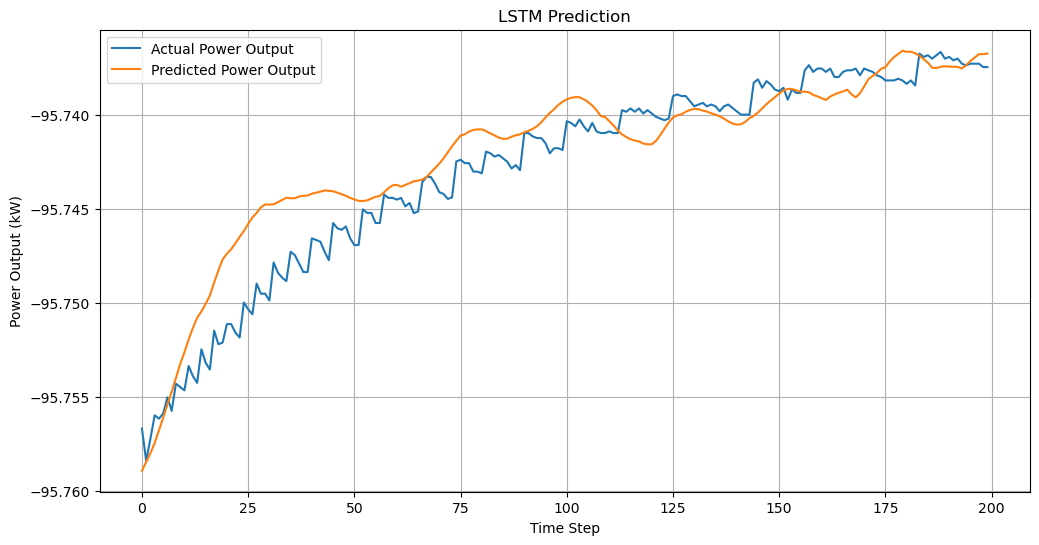

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Power Output')
plt.plot(y_pred_inv, label='Predicted Power Output')
plt.title('LSTM Prediction')
plt.xlabel('Time Step')
plt.ylabel('Power Output (kW)')
plt.legend()
plt.grid(True)
plt.show()


TRANSFORMERS

In [41]:
solar_power.shape

(1009, 13)

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D, Add

In [43]:
print(features.columns)
print(solar_power.head())

Index(['Solar_Radiation', 'Air_Temp', 'Relative_Humidity', 'Wind_Speed',
       'Wind_Direction', 'Array_Voltage', 'Array_Current'],
      dtype='object')
                      Air_Temp  Relative_Humidity  Wind_Speed  Wind_Direction  \
Timestamp                                                                       
2022-04-27 15:32:00  43.349172          12.790256    0.533333      118.786620   
2022-04-27 15:34:00  43.433980          11.468986    1.866667       84.681408   
2022-04-27 15:36:00  43.286580          11.047298    2.866667       40.807156   
2022-04-27 15:38:00  43.523020          12.058292    0.000000       66.390848   
2022-04-27 15:40:00  43.728656          10.722330    2.266667        2.127408   

                     Solar_Radiation       RTD_1      RTD_2      RTD_3  \
Timestamp                                                                
2022-04-27 15:32:00        707.53384   98.289640  94.283552  89.002824   
2022-04-27 15:34:00        710.46328   98.377480  94.17

In [44]:
print('Power_Generated' in solar_power.columns)  # Returns True or False
print(features.columns.tolist())


True
['Solar_Radiation', 'Air_Temp', 'Relative_Humidity', 'Wind_Speed', 'Wind_Direction', 'Array_Voltage', 'Array_Current']


In [45]:
# Preprocessing
# Extract features
features = solar_power[['Solar_Radiation', 'Air_Temp', 'Relative_Humidity',
                        'Power_Generated', 'Wind_Speed', 'Wind_Direction',
                        'Array_Voltage', 'Array_Current']].copy()

features.columns = features.columns.str.strip()

In [46]:
target_col = 'Power_Generated'
target_index = features.columns.get_loc(target_col)

In [47]:
# Scale all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

In [48]:
#Sequence Creation
def create_sequences(data, seq_length, target_index):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_x = data[i:i+seq_length]
        seq_y = data[i+seq_length, target_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

SEQ_LEN = 23
X, y = create_sequences(scaled_data, SEQ_LEN, target_index)

Converts the time-series into overlapping sequences for Transformer input:

X: previous seq_length timesteps of data.
y: the value to predict after that sequence.

In [49]:
# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Transformer layer has 6 encoders and 6 decoders.

1. Input Embedding: Each token in the input sequence is converted into a dense vector representation. This step is crucial for enabling the model to process textual data numerically.
2. Positional encodings—a crucial concept in Transformer models that lets the model capture the order of sequences, since unlike RNNs, Transformers have no inherent sense of sequence.

In [50]:
# Positional Encoding
def get_positional_encoding(seq_len, d_model): #d_model: the dimension of the embeddings
# Generate Position & Index Grids
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]

    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates #Compute Angles
    # Apply Sin and Cos to Alternating Columns
    pos_encoding = np.zeros(angle_rads.shape)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
   
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

Apply Sin and Cos to Alternating Columns
sin to even indices [0, 2, 4, ...]
cos to odd indices [1, 3, 5, ...]

This alternating pattern allows the model to distinguish between different positions.

class TransformerBlock(Layer): Defines a custom Transformer block: 
Multi-head attention
Feedforward layers
LayerNorm
Dropout

def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):

embed_dim: dimensionality of the input (i.e., size of embedding vector).
num_heads: number of attention heads.
ff_dim: dimensionality of the feed-forward layer.
rate: dropout rate, default 10%.

Transformer Block:
Input
  ↓
Multi-Head Attention + Dropout → Add & LayerNorm
  ↓
Feed-Forward + Dropout → Add & LayerNorm
  ↓
Output

and

Input
  ↓
Self-Attention → Dropout → Add (Residual) → LayerNorm
  ↓
Feed-Forward → Dropout → Add (Residual) → LayerNorm
  ↓
Output


In [51]:
# Transformer Block
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim) 
        # Multi-head self-attention layer: Each head independently performs attention on the input
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
             ])
#Feed-Forward Network (FFN): First dense layer expands to ff_dim units with ReLU activation (non-linearity).
# Second dense layer compresses back to embed_dim (original size) — helps preserve dimensionality after transformation.
       
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

        
    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training) # Regularization step — prevents overfitting during training.
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


attn_output = self.att(inputs, inputs, training=training): This layer lets each position in the input attend to every other position in the sequence.

The input is passed as:
Query = inputs
Key = inputs
Value = inputs

So it's self-attention.

In [52]:
# Model Architecture
def build_transformer_model(seq_len, num_features, embed_dim=64, num_heads=4, ff_dim=128):
    inputs = Input(shape=(seq_len, num_features))
    x = Dense(embed_dim)(inputs)

    # Add positional encoding
    pos_encoding = get_positional_encoding(seq_len, embed_dim)
    x = x + pos_encoding

    # Transformer block
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    # Global average pooling: Converts sequence into a fixed-size vector

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x) # 64 neurons 
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Use correct number of features
model = build_transformer_model(seq_len=SEQ_LEN, num_features=X.shape[2])
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=64)

# Predict & Inverse scale
y_pred = model.predict(X_test).flatten()

# Inverse scaling
target_min = scaler.data_min_[target_index]
target_range = scaler.data_max_[target_index] - target_min
y_test_inv = y_test * target_range + target_min
y_pred_inv = y_pred * target_range + target_min

# MinMaxScaler scaled all values between 0 and 1.
# This step inverts that scaling for Power_Generated so predictions are in real-world units (Watts):
# original_value = scaled_value * range + min

# Evaluation
print("MAE:", mean_absolute_error(y_test_inv, y_pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print("R2 Score:", r2_score(y_test_inv, y_pred_inv))


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 23, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 23, 64)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_5 (Add)                     │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, 23, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,001 (343.75 KB)

 Trainable params: 88,001 (343.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.3096 - val_loss: 0.0529
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0335 - val_loss: 0.0036
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0179 - val_loss: 0.0033
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0112 - val_loss: 0.0046
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0104 - val_loss: 0.0030
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0106 - val_loss: 0.0026
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0120 - val_loss: 0.0033
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0079 - val_loss: 0.0029
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0085 - val_loss: 0.0018
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0078 - val_loss: 0.0020
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

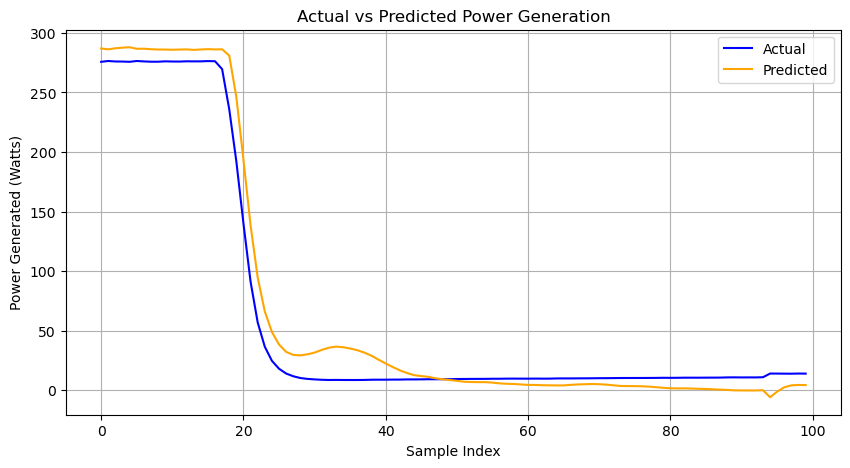

In [53]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:100], label='Actual', color='blue')
plt.plot(y_pred_inv[:100], label='Predicted', color='orange')
plt.title('Actual vs Predicted Power Generation')
plt.xlabel('Sample Index')
plt.ylabel('Power Generated (Watts)')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
pip install torch pandas scikit-learn

   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
    --------------------------------------- 2.9/212.5 MB 15.3 MB/s eta 0:00:14
    --------------------------------------- 5.2/212.5 MB 13.9 MB/s eta 0:00:15
   - -------------------------------------- 8.4/212.5 MB 13.7 MB/s eta 0:00:15
   -- ------------------------------------- 10.7/212.5 MB 13.2 MB/s eta 0:00:16
   -- ------------------------------------- 13.9/212.5 MB 13.9 MB/s eta 0:00:15
   --- ------------------------------------ 17.8/212.5 MB 14.6 MB/s eta 0:00:14
   --- ------------------------------------ 21.2/212.5 MB 14.9 MB/s eta 0:00:13
   ---- ----------------------------------- 24.1/212.5 MB 14.8 MB/s eta 0:00:13
   ----- ---------------------------------- 27.5/212.5 MB 14.9 MB/s eta 0:00:13
   ----- ---------------------------------- 30.7/212.5 MB 15.0 MB/s eta 0:00:13
   ------ --------------------------------- 34.3/212.5 MB 15.1 MB/s eta 0:00:12
   ------- -------------------------------- 38.0/212

In [5]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

timestamps = pd.date_range(start="2022-04-30", periods=720, freq="5min")
data = pd.DataFrame({
    "Timestamp": timestamps,
    "Solar_Radiation": np.random.rand(720) * 1000,
    "Air_Temp": np.random.rand(720) * 40,
    "Relative_Humidity": np.random.rand(720) * 100,
    "Power_Generated": np.random.rand(720) * 500
})

# Features and scaling
features = ['Solar_Radiation', 'Air_Temp', 'Relative_Humidity', 'Power_Generated']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])
target_idx = features.index('Power_Generated')

# Create sequence
SEQ_LEN = 24
FUTURE_STEPS = 10

def create_sequences(data, seq_len, future_steps, target_index):
    X, y = [], []
    for i in range(len(data) - seq_len - future_steps + 1):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+future_steps, target_index])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQ_LEN, FUTURE_STEPS, target_idx)
X_train, y_train = X[:-100], y[:-100]
X_test, y_test = X[-100:], y[-100:]

# Transformer model
class TransformerPredictor(nn.Module):
    def __init__(self, input_dim, model_dim, nhead, num_layers, output_len):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(model_dim, output_len)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.output(x[:, -1])

model = TransformerPredictor(input_dim=X.shape[2], model_dim=64, nhead=4, num_layers=2, output_len=FUTURE_STEPS)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    inputs = torch.tensor(X_train, dtype=torch.float32)
    targets = torch.tensor(y_train, dtype=torch.float32)
    preds = model(inputs)
    loss = criterion(preds, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

# Predict on latest known sequence
model.eval()
last_sequence = torch.tensor(scaled_data[-SEQ_LEN:], dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    pred_scaled = model(last_sequence).numpy().flatten()

# Inverse transform predictions
temp = np.zeros((FUTURE_STEPS, len(features)))
temp[:, target_idx] = pred_scaled
pred_rescaled = scaler.inverse_transform(temp)[:, target_idx]

# Generate future timestamps
last_time = data["Timestamp"].iloc[-1]
future_timestamps = [last_time + timedelta(minutes=5 * (i + 1)) for i in range(FUTURE_STEPS)]

# Final output
forecast_df = pd.DataFrame({
    "Timestamp": future_timestamps,
    "Predicted_Power_Generated": pred_rescaled
})

print(forecast_df)


Epoch 1/20, Loss: 1.4292
Epoch 2/20, Loss: 0.2674
Epoch 3/20, Loss: 0.1993
Epoch 4/20, Loss: 0.1704
Epoch 5/20, Loss: 0.1486
Epoch 6/20, Loss: 0.1383
Epoch 7/20, Loss: 0.1304
Epoch 8/20, Loss: 0.1296
Epoch 9/20, Loss: 0.1253
Epoch 10/20, Loss: 0.1226
Epoch 11/20, Loss: 0.1164
Epoch 12/20, Loss: 0.1112
Epoch 13/20, Loss: 0.1079
Epoch 14/20, Loss: 0.1055
Epoch 15/20, Loss: 0.1065
Epoch 16/20, Loss: 0.1046
Epoch 17/20, Loss: 0.1053
Epoch 18/20, Loss: 0.1059
Epoch 19/20, Loss: 0.1047
Epoch 20/20, Loss: 0.1041
            Timestamp  Predicted_Power_Generated
0 2022-05-02 12:00:00                 308.965992
1 2022-05-02 12:05:00                 269.721318
2 2022-05-02 12:10:00                 262.985613
3 2022-05-02 12:15:00                 273.587825
4 2022-05-02 12:20:00                 224.076593
5 2022-05-02 12:25:00                 195.123850
6 2022-05-02 12:30:00                 235.152474
7 2022-05-02 12:35:00                 172.368391
8 2022-05-02 12:40:00                 262.114719